### Import libraries

In [1]:
import math

In [2]:
from joblib import Parallel, delayed

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [6]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [7]:
from pmdarima import auto_arima

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [9]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [10]:
import warnings
warnings.filterwarnings("ignore");

In [11]:
import logging
logging.getLogger("cmdstanpy").disabled = True

### Loading dataset

In [12]:
df = pd.read_csv('purchases_monthly.csv')

In [13]:
df.head()

,dim_product_sk,year_month,amount,quantity,year,month
0,5,2019-01,4008.34,95.0,2019,1
1,5,2019-02,8282.05,197.0,2019,2
2,5,2019-03,5168.46,123.0,2019,3
3,5,2019-04,3659.85,87.0,2019,4
4,5,2019-05,6643.27,158.0,2019,5


### Data information

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180831 entries, 0 to 180830
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dim_product_sk  180831 non-null  int64  
 1   year_month      180831 non-null  object 
 2   amount          180831 non-null  float64
 3   quantity        180831 non-null  float64
 4   year            180831 non-null  int64  
 5   month           180831 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 8.3+ MB


### Data Cleaning

### Check for missing values

In [15]:
print(f"Number of rows with missing values: \n{df.isna().sum()}")

Number of rows with missing values: 
dim_product_sk    0
year_month        0
amount            0
quantity          0
year              0
month             0
dtype: int64


### Check for duplicate values

In [16]:
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 0


### Check for negative values

In [17]:
print(f"Negative quantity rows: {(df['quantity'] < 0).sum()}")
print(f"Negative amount rows: {(df['amount'] < 0).sum()}")

Negative quantity rows: 0
Negative amount rows: 0


### Univariate analysis

### Unique products

In [18]:
print(f"Unique SK Products : {df['dim_product_sk'].nunique()}")

Unique SK Products : 2289


### Monthly sold quantity

<Axes: xlabel='month'>

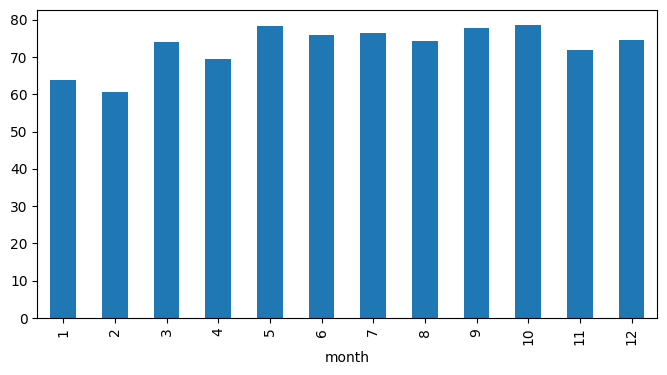

In [19]:
df.groupby('month')['quantity'].mean().plot(kind="bar", figsize=(8, 4))

### Monthly sold amount

<Axes: xlabel='month'>

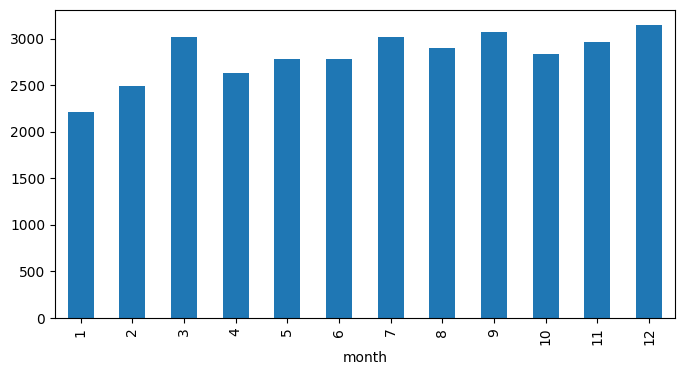

In [20]:
df.groupby('month')['amount'].mean().plot(kind="bar", figsize=(8,4))

### Yearly sold quantity

<Axes: xlabel='year'>

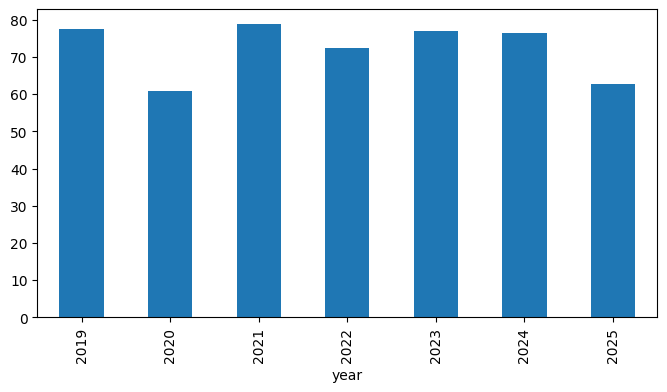

In [21]:
df.groupby('year')['quantity'].mean().plot(kind='bar', figsize=(8,4))

### Yearly sold amount

<Axes: xlabel='year'>

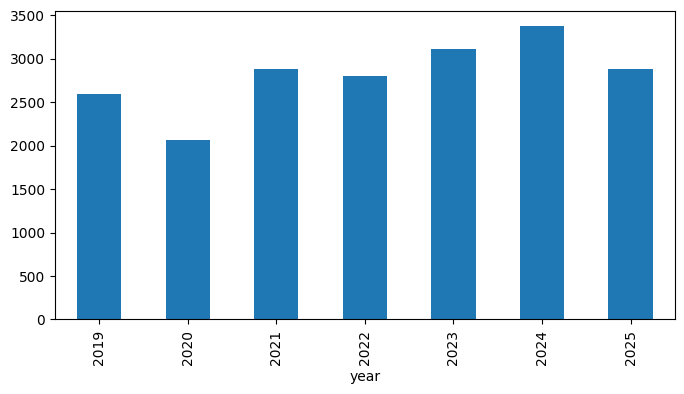

In [22]:
df.groupby('year')['amount'].mean().plot(kind='bar', figsize=(8,4))

### Decomposition

In [23]:
df['year_month'] = pd.to_datetime(df['year_month'])

### Visualizing for trends

In [24]:
df_trends = df.groupby('year_month')['quantity'].sum()

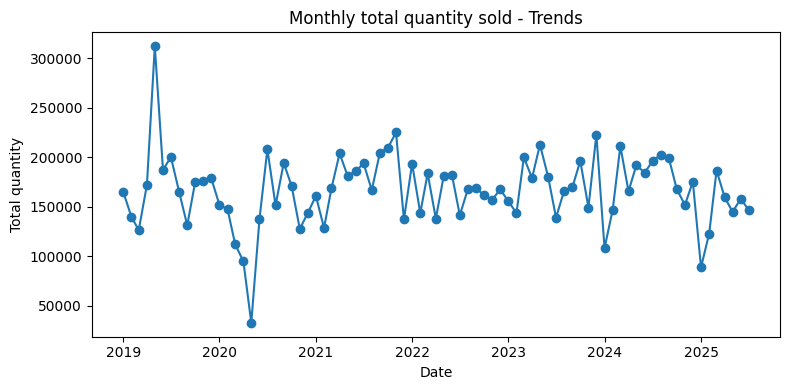

In [25]:
plt.figure(figsize=(8,4))
plt.plot(df_trends.index, df_trends.values, label="Quantity sold", marker = 'o')
plt.title('Monthly total quantity sold - Trends')
plt.xlabel('Date')
plt.ylabel('Total quantity')
plt.tight_layout()
plt.show()

### Visualizing for seasonality

In [26]:
df_seasonality = df.groupby('month')['quantity'].mean()

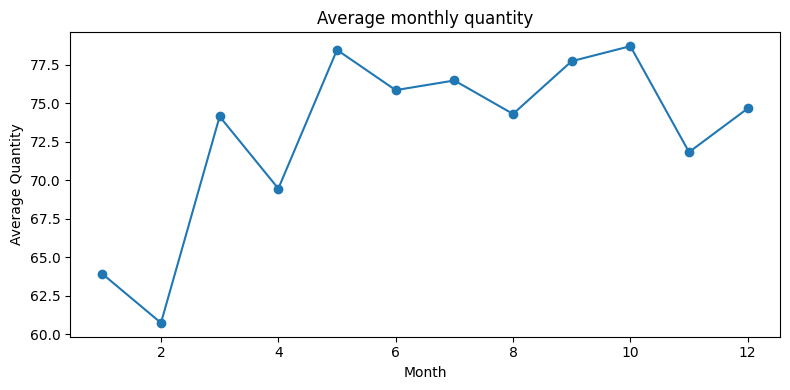

In [27]:
plt.figure(figsize=(8, 4))
plt.plot(df_seasonality.index, df_seasonality.values, marker='o', label='Quantity sold')
plt.title('Average monthly quantity')
plt.xlabel('Month')
plt.ylabel('Average Quantity')
plt.tight_layout()
plt.show()

### Visualizing noise

In [28]:
df_ts_decomposition = seasonal_decompose(df['quantity'], model='additive', period=12)

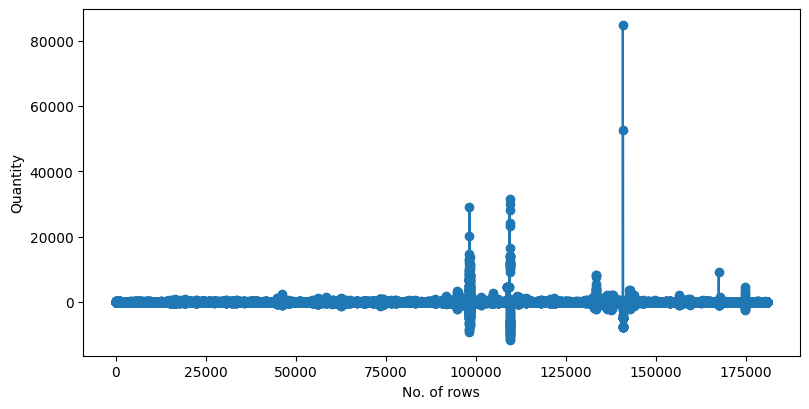

In [29]:
plt.figure(figsize=(8,4))
residuals = df_ts_decomposition.resid
reisduals = residuals.dropna()
plt.plot(residuals.index, residuals, label="Noise", marker='o')
plt.tight_layout()
plt.xlabel('No. of rows')
plt.ylabel('Quantity')
plt.show()

## ADF test

In [30]:
df_monthly = df.groupby('year_month')['quantity'].sum()

In [31]:
adftest_result = adfuller(df_monthly)

In [32]:
print('ADF Test on monthly quantity \n')
print("ADF Test Statistic:", adftest_result[0])
print(f"p-value: , {adftest_result[1]:.10f}")
print("Lags Used:", adftest_result[2])
print("Number of Observations:", adftest_result[3])

print("Critical Values:")
for key, value in adftest_result[4].items():
    print(f"   {key}: {value:.3f}")

if adftest_result[1] <= 0.05:
    print("Series is stationary - reject null hypothesis")
else:
    print("Series is non-stationary - (fail to reject null hypothesis)")

ADF Test on monthly quantity 

ADF Test Statistic: -6.77095996513049
p-value: , 0.0000000026
Lags Used: 0
Number of Observations: 78
Critical Values:
   1%: -3.517
   5%: -2.899
   10%: -2.587
Series is stationary - reject null hypothesis


### Autocorrelation function test

<Figure size 800x400 with 0 Axes>

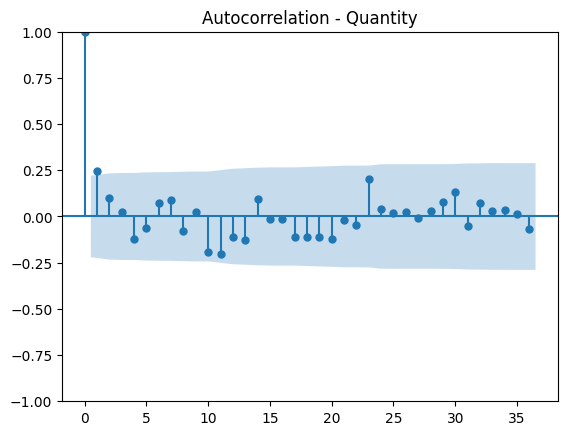

In [33]:
plt.figure(figsize=(8, 4))
plot_acf(df_monthly, lags=36)
plt.title("Autocorrelation - Quantity")
plt.show()

### Partial autocorrelation function test

<Figure size 800x400 with 0 Axes>

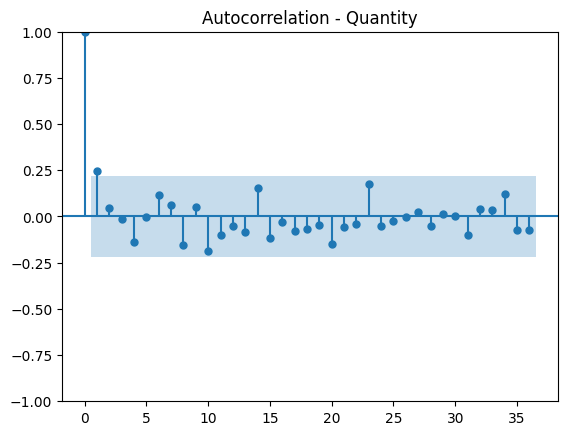

In [34]:
plt.figure(figsize=(8, 4))
plot_pacf(df_monthly, lags=36)
plt.title("Autocorrelation - Quantity")
plt.show()

# Prophet model
Prophet model is designed as a univariate time series forecasting. We have one datetime column and one target column.

### Feauture selection for Prophet model

In [35]:
df_for_prophet = df.drop(columns=['year', 'month', 'dim_product_sk', 'amount'], axis=1)

In [36]:
df_for_prophet.head()

,year_month,quantity
0,2019-01-01,95.0
1,2019-02-01,197.0
2,2019-03-01,123.0
3,2019-04-01,87.0
4,2019-05-01,158.0


### Grouping
Grouping quantites of all products by months.

In [37]:
df_final = (
    df_for_prophet.groupby('year_month', as_index=False).agg({'quantity': 'sum'})
)

In [38]:
df_for_prophet = df_final.copy()

In [39]:
df_for_prophet.head(5)

,year_month,quantity
0,2019-01-01,165313.0
1,2019-02-01,140022.0
2,2019-03-01,126374.0
3,2019-04-01,172013.0
4,2019-05-01,312183.0


In [40]:
df_for_prophet['year_month'] = pd.to_datetime(df_for_prophet['year_month'])

### Changing column names

In [41]:
df_for_prophet = df_for_prophet[['year_month', 'quantity']].rename(columns={'year_month':'ds', 'quantity' : 'y'})

In [42]:
df_for_prophet.head(2)

,ds,y
0,2019-01-01,165313.0
1,2019-02-01,140022.0


### Train test split

In [43]:
H = 12 # 12 months 

In [44]:
train = df_for_prophet.iloc[:-H].copy()
test = df_for_prophet.iloc[-H:].copy()

### Defining model

In [45]:
prophet_model = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    interval_width=0.80    
)

### Fitting model

In [46]:
prophet_model.fit(train)

### Forecasting

In [47]:
future = prophet_model.make_future_dataframe(periods=H, freq='MS')

In [48]:
forecast = prophet_model.predict(future)

### Model Evaluation

In [49]:
pred_vs_actual = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_for_prophet.set_index('ds')['y'])

In [50]:
pred_test = pred_vs_actual.loc[test['ds']]

In [51]:
y_true = pred_test['y'].values

In [52]:
y_pred  = pred_test['yhat'].values

In [53]:
prophet_mae  = mean_absolute_error(y_true, y_pred)
prophet_mse = mean_squared_error(y_true, y_pred)
prophet_rmse = math.sqrt(prophet_mse)
prophet_mape = (np.abs((y_true - y_pred) / y_true).mean() * 100)
prophet_accuracy = 100-prophet_mape

In [54]:
print("\nModel Evaluation\n")
print(f"MAE:  {prophet_mae:,.2f}")
print(f"MSE:  {prophet_mse:,.2f}")
print(f"RMSE: {prophet_rmse:,.2f}")
print(f"MAPE: {prophet_mape:.2f}%")
print(f"Accuracy: {prophet_accuracy:.2f}%")


Model Evaluation

MAE:  31,128.04
MSE:  1,720,680,607.96
RMSE: 41,481.09
MAPE: 24.29%
Accuracy: 75.71%


### Final Forecasting

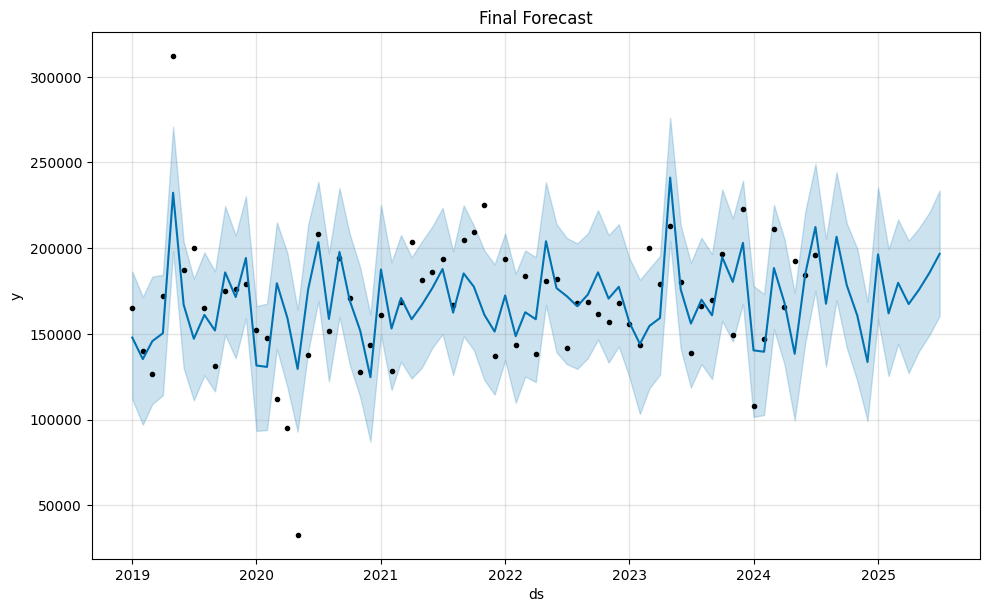

In [55]:
fig1 = prophet_model.plot(forecast)
plt.title('Final Forecast')
plt.show()

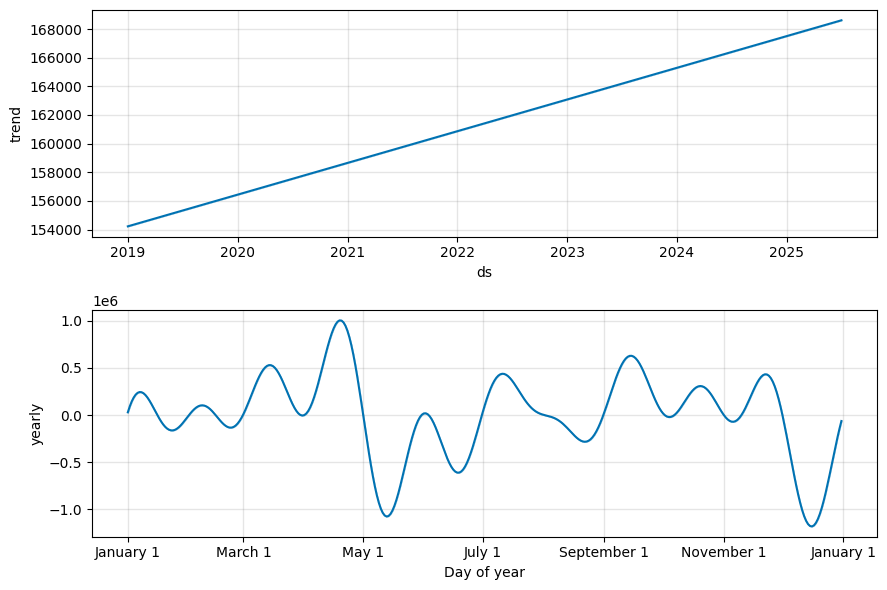

In [56]:
fig2 = prophet_model.plot_components(forecast)
plt.show()

### Forecasting 2026

In [57]:
future = prophet_model.make_future_dataframe(periods=24, freq='MS')

In [58]:
forecast = prophet_model.predict(future)

In [59]:
forecast_2026 = forecast[forecast['ds'].dt.year == 2026]
print(forecast_2026[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

           ds           yhat     yhat_lower     yhat_upper
84 2026-01-01  181254.911743  146291.844276  217200.621659
85 2026-02-01  157476.423243  119949.059736  193644.260027
86 2026-03-01  171449.858184  135668.782999  207570.687369
87 2026-04-01  167382.470473  129894.021607  203964.420450
88 2026-05-01  212909.217983  177051.693187  248998.252926
89 2026-06-01  185536.430151  145845.289778  221683.774018
90 2026-07-01  180846.744055  144563.935921  218750.562388


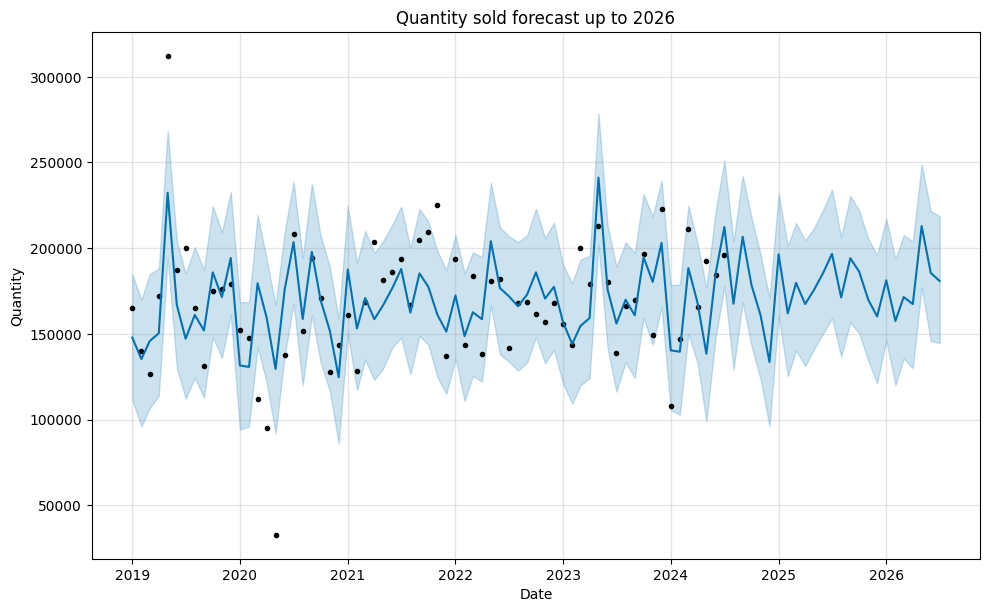

In [60]:
fig = prophet_model.plot(forecast)
plt.title("Quantity sold forecast up to 2026")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.show()

# ARIMA

ARIMA for forecasting

In [61]:
df_arima = df_final.copy()

### Train test split

In [62]:
split = int(len(df_final) * 0.8) 

In [63]:
train = df_arima['quantity'][:split]
test = df_arima['quantity'][split:]

In [64]:
print(f"Training set: {len(train)} observations")
print(f"Test set: {len(test)} observations")

Training set: 63 observations
Test set: 16 observations


### Auto ARIMA

In [65]:
y = train

In [66]:
auto_model = auto_arima(
    y,
    start_p=0, start_q=0,
    max_p=5, max_q=5, 
    d=1,           
    seasonal=False,   
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1513.845, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1505.185, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1502.215, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1511.868, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1507.293, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1509.211, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1500.512, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1496.651, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1503.261, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1501.959, Time=0.01 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0

In [67]:
print(f"Best model: {auto_model.order}")

Best model: (1, 1, 1)


### Final ARIMA model

In [68]:
best_order = auto_model.order

In [69]:
final_model = ARIMA(y, order=best_order)

### Fit ARIMA

In [70]:
arima_fitted = final_model.fit()

### Summary of ARIMA

In [71]:
print(arima_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                   63
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -745.325
Date:                Sun, 05 Oct 2025   AIC                           1496.651
Time:                        12:14:04   BIC                           1503.032
Sample:                             0   HQIC                          1499.156
                                 - 63                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3168      0.112      2.824      0.005       0.097       0.537
ma.L1         -0.9794      0.069    -14.286      0.000      -1.114      -0.845
sigma2      1.379e+09   4.92e-11    2.8e+19      0.0

### Forecast using ARIMA

In [72]:
forecast = arima_fitted.forecast(steps=len(test))

### ARIMA model Evaluation

In [73]:
arima_mae = mean_absolute_error(test, forecast)
arima_mse = mean_squared_error(test, forecast)
arima_rmse = np.sqrt(arima_mse)
arima_mape = (np.abs((test - forecast) / test).mean() * 100)
arima_accuracy = 100-arima_mape

In [74]:
print("\nModel Evaluation: \n")
print(f"MAE:  {arima_mae:,.2f}")
print(f"MSE:  {arima_mse:,.2f}")
print(f"RMSE: {arima_rmse:,.2f}")
print(f"MAPE: {arima_mape:.2f}%")
print(f"Accuracy: {arima_accuracy:.2f}%")


Model Evaluation: 

MAE:  23,346.82
MSE:  856,831,771.52
RMSE: 29,271.69
MAPE: 16.51%
Accuracy: 83.49%


# SARIMAX
Forecasting with SARIMAX

In [75]:
df_sarimax = df_final.copy()
df_sarimax['year_month'] = pd.to_datetime(df_sarimax['year_month'])
df_sarimax = df_sarimax.set_index('year_month')

### Train Test Split

In [76]:
train = df_sarimax[:split]
y_train = train['quantity']
test = df_sarimax[split:]

### Auto Arima
To find best order

In [77]:
model = auto_arima(
    y_train,
    seasonal = True,
    m=12,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1510.382, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1510.254, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1509.305, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1699.318, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1509.620, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1511.235, Time=0.29 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=1511.072, Time=0.09 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1511.442, Time=0.06 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=1513.008, Time=0.14 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1508.878, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1510.851, Time=0.33 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=1510.874, Time=0.07 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1512.251, Time=0.02 sec
 ARIMA(0,0,0)(1,0,2)[12]

### Model summary

In [78]:
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                   63
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                -750.407
Date:                              Sun, 05 Oct 2025   AIC                           1508.815
Time:                                      12:14:07   BIC                           1517.387
Sample:                                  01-01-2019   HQIC                          1512.187
                                       - 03-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.291e+05   2.82e+04      4.582      0.000    7.39e+04    1.84e+05
ar.L1          0.22

### Best order

In [79]:
print("Best order (p,d,q): ", model.order) 

Best order (p,d,q):  (1, 0, 0)


### Seasoanl order

In [80]:
print("Best seasonal order (P,D,Q,m): ", model.seasonal_order)

Best seasonal order (P,D,Q,m):  (0, 0, 1, 12)


### Forecast

In [81]:
sarimax_model = SARIMAX(
    y_train,
    order=model.order,
    seasonal_order=model.seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

### Fitting Sarimax model

In [82]:
final_sarimax = sarimax_model.fit(disp=False)

In [83]:
print(final_sarimax.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             quantity   No. Observations:                   63
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                -604.486
Date:                              Sun, 05 Oct 2025   AIC                           1214.972
Time:                                      12:14:07   BIC                           1220.708
Sample:                                  01-01-2019   HQIC                          1217.156
                                       - 03-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9830      0.037     26.610      0.000       0.911       1.055
ma.S.L12      -0.15

### Forecast using Sarimax

In [84]:
n = len(test)

In [85]:
forecast = final_sarimax.get_forecast(steps=n)
forecast_mean = forecast.predicted_mean
forecast_confidence_interval = forecast.conf_int()

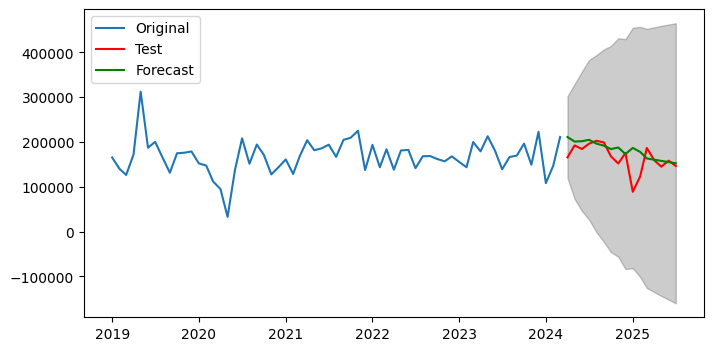

In [86]:
plt.figure(figsize=(8,4))
plt.plot(train.index, train['quantity'], label="Original")
plt.plot(test.index, test['quantity'], label='Test', color='red')
plt.plot(forecast_mean.index, forecast_mean, label="Forecast", color='green')
plt.fill_between(forecast_confidence_interval.index,
                 forecast_confidence_interval.iloc[:,0],
                 forecast_confidence_interval.iloc[:,1],
                 color='k', alpha=0.2)
plt.legend()
plt.show()

### Sarimax evaluation

In [87]:
y_true = test['quantity']
y_pred = forecast_mean

In [88]:
sarimax_mse = mean_squared_error(y_true, y_pred)
sarimax_rmse = np.sqrt(sarimax_mse)
sarimax_mae = mean_absolute_error(y_true, y_pred)
sarimax_mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
sarimax_accuracy = 100-sarimax_mape

In [89]:
print("\nModel Evaluation: \n")
print(f"MAE: {sarimax_mae:.2f}")
print(f"MSE: {sarimax_mse:.2f}")
print(f"RMSE:  {sarimax_rmse:.2f}")
print(f"MAPE: {sarimax_mape:.2f}%")
print(f"Accuracy: {sarimax_accuracy:.2f}%")


Model Evaluation: 

MAE: 21703.44
MSE: 1093994457.31
RMSE:  33075.59
MAPE: 16.89%
Accuracy: 83.11%


# LSTM

In [90]:
df_lstm = df_final.copy()

### Feature engineering for LSTM

In [91]:
df_lstm['year_month'] = pd.to_datetime(df_lstm['year_month'])
df_lstm = df_lstm.set_index('year_month')
input_series = df_lstm['quantity'].astype(float)

### Scaling series

In [92]:
scaler = MinMaxScaler(feature_range=(0,1))

In [93]:
scaled_input_series = scaler.fit_transform(input_series.values.reshape(-1, 1))

### Creating sequence
LSTM is a supervised learning algorithm, create a sequence of X,y from time series dataset.

In [94]:
def create_sequences(data, sequence_length = 12):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

In [95]:
seq_length = 12
X, y = create_sequences(scaled_input_series, seq_length)

### Train Test split

In [96]:
split = int(len(X) * 0.8)

In [97]:
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

### Making input 3D
LSTM expects 3D input.

In [98]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### Building model

In [99]:
model = Sequential()

In [100]:
model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))

### Compile model

In [101]:
model.compile(optimizer='adam', loss='mse')

### Model summary

In [102]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 12, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

### Training LSTM on our sequence

In [103]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    verbose=1
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 0.2561 - val_loss: 0.1214
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1180 - val_loss: 0.0242
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0223 - val_loss: 0.0359
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0414 - val_loss: 0.0331
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0280 - val_loss: 0.0124
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0241 - val_loss: 0.0169
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0261 - val_loss: 0.0166
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0310 - val_loss: 0.0131
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0222 - val_loss: 0.0127
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0216 - val_loss: 0.0138
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0173 - val_loss: 0.0135
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0220 - val_loss: 0.0124


### Visualizing Train vs Validation loss

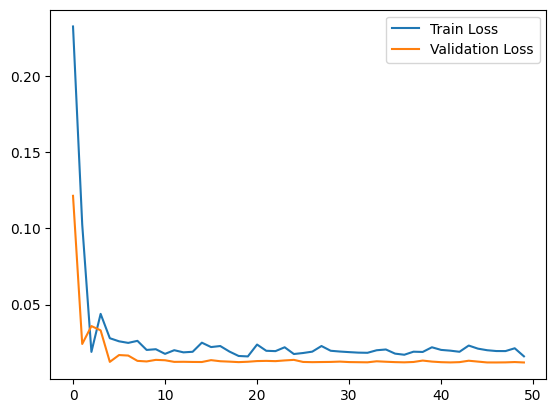

In [104]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

### Model prediction

In [105]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


### LSTM Evaluation

In [106]:
lstm_mse = mean_squared_error(y_test_actual, y_pred)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_actual, y_pred)
lstm_mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
lstm_accuracy = 100 - lstm_mape

In [107]:
print(f"MSE: {lstm_mse:.2f}")
print(f"RMSE: {lstm_rmse:.2f}")
print(f"MAE: {lstm_mae:.2f}")
print(f"MAPE: {lstm_mape:.2f}%")
print(f"Accuracy: {lstm_accuracy:.2f}%")

MSE: 941368630.54
RMSE: 30681.73
MAE: 23103.47
MAPE: 16.59%
Accuracy: 83.41%


### Predicted vs Actual

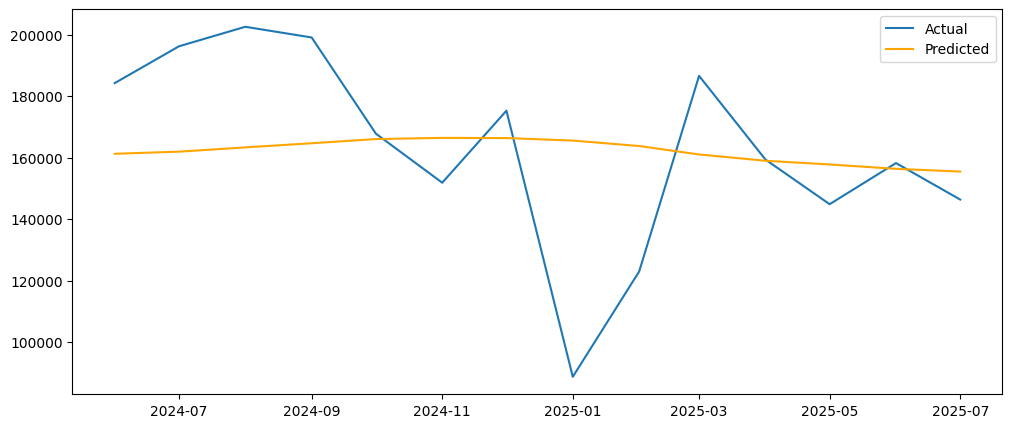

In [108]:
plt.figure(figsize=(12,5))
plt.plot(input_series.index[-len(y_test_actual):], y_test_actual, label='Actual')
plt.plot(input_series.index[-len(y_test_actual):], y_pred, label='Predicted', color='orange')
plt.legend()
plt.show()

### Forecasting future

In [109]:
future_preds = []
last_seq = scaled_input_series[-seq_length:] 

current_seq = last_seq.reshape(1, seq_length, 1)

for _ in range(12):
    next_pred = model.predict(current_seq)[0]
    future_preds.append(next_pred)
    current_seq = np.append(current_seq[:,1:,:], [[next_pred]], axis=1)

future_preds = scaler.inverse_transform(future_preds)

last_date = input_series.index[-1]
future_dates = pd.date_range(last_date + pd.offsets.MonthBegin(), periods=12, freq='MS')

forecast_df = pd.DataFrame({'ds': future_dates, 'forecast': future_preds.flatten()})
print("\nForecasted series: \n")
print(forecast_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Forecasted series: 

           ds       forecast
0  2025-08-01  154545.504607
1  2025-09-01  153871.223541
2  2025-10-01  153471.265541
3  2025-11-01  153531.238837
4  2025-12-01  153776.737076
5  2026-01-01  153784.066128
6  2026-02-01  154628.089692
7  2026-03-01  154924.791351
8  2026-04-01  154581.375317
9  2026-05-01  154608.950873
10 2026-06-01  154783.240715
11 2026-07-01  154803.936957


# Model Comparison

In [110]:
results = {
    "Model": ["LSTM", "ARIMA", "Prophet", "SARIMAX"],
    "MSE": [lstm_mse, arima_mse, prophet_mse, sarimax_mse],
    "RMSE": [lstm_rmse, arima_rmse, prophet_rmse, sarimax_rmse],
    "MAE": [lstm_mae, arima_mae, prophet_mae, sarimax_mae],
    "MAPE (%)": [lstm_mape, arima_mape, prophet_mape, sarimax_mape],
    "Accuracy (%)": [lstm_accuracy, arima_accuracy, prophet_accuracy, sarimax_accuracy]
}
pd.set_option("display.float_format", "{:,.2f}".format)
comparison_df = pd.DataFrame(results)

In [111]:
comparison_df

,Model,MSE,RMSE,MAE,MAPE (%),Accuracy (%)
0,LSTM,"941,368,630.54","30,681.73","23,103.47",16.59,83.41
1,ARIMA,"856,831,771.52","29,271.69","23,346.82",16.51,83.49
2,Prophet,"1,720,680,607.96","41,481.09","31,128.04",24.29,75.71
3,SARIMAX,"1,093,994,457.31","33,075.59","21,703.44",16.89,83.11


### Training models to forecast for each SKU

In [112]:
df.head()

,dim_product_sk,year_month,amount,quantity,year,month
0,5,2019-01-01,"4,008.34",95.00,2019,1
1,5,2019-02-01,"8,282.05",197.00,2019,2
2,5,2019-03-01,"5,168.46",123.00,2019,3
3,5,2019-04-01,"3,659.85",87.00,2019,4
4,5,2019-05-01,"6,643.27",158.00,2019,5


In [113]:
df['year_month'] = pd.to_datetime(df['year_month'])

In [114]:
arima_models = {}

### Fitting ARIMA per unique product

In [115]:
for sku, group in df.groupby('dim_product_sk'):

    series = group.set_index('year_month')['quantity'].asfreq('MS')

    try:
        arima_model = ARIMA(series, order=(1, 1, 1))
        fitted_model = arima_model.fit()
        arima_models[sku] = fitted_model
    except Exception as e:
        print(f'Training failed for SKU: {sku}, Reason : {e}')    

### Fitting fbProphet per unique product

In [116]:
def fit_fbProphet(sku, group):
    data = group[['year_month', 'quantity']].rename(columns={'year_month': 'ds', 'quantity': 'y'})
    try:
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False
        )
        model.fit(data)
        return sku, model
    except Exception as e:
        print(f"Prophet failed for SKU {sku}: {e}")
        return sku, None

results = Parallel(n_jobs=-1, verbose = 5)(
    delayed(fit_fbProphet)(sku, group) for sku,group in df.groupby('dim_product_sk')
)

prophet_models = {sku: model for sku, model in results if model is not None}

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 2289 out of 2289 | elapsed: 10.2min finished


### Fitting SARIMAX per unique product

In [117]:
sarimax_models = {}

In [ ]:
for sku, group in df.groupby('dim_product_sk'):

    try:
        series = group.set_index('year_month')['quantity'].asfreq('MS').fillna(0)
        sarimax_model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(1,1,1,12))
        fitted_model = sarimax_model.fit()
        sarimax_models[sku] = fitted_model
    except Exception as e:
        print(f"SARIMAX failed for SKU {sku}: {e}")
    

### Forecasting

In [ ]:
def forecast_product(sku, model="prophet", periods = 12):
    if model == "arima": 
        if sku not in arima_models:
            raise ValueError(f"SKU : {sku} not found in trained arima models.")
        fitted_model = arima_models[sku]
        forecast = fitted_model.forecast(steps=periods)
        return forecast
    elif model == "prophet":
        if sku not in prophet_models:
            raise ValueError(f"Prophet model for SKU {sku} not found.")
        fitted_model = prophet_models[sku]
        future = fitted_model.make_future_dataframe(periods=periods, freq="MS")
        forecast = fitted_model.predict(future)
        forecast['yhat'] = forecast['yhat'].clip(lower=0)
        forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
        forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)
        return forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(periods)
    elif model == "sarimax":
        if sku not in sarimax_models: raise ValueError(f"SKU {sku} not in SARIMAX models")
        model = sarimax_models[sku]
        forecast = model.get_forecast(steps=periods)
        return forecast.predicted_mean
    else:
        raise ValueError("Model type must be 'arima','prophet', 'sarimax', or 'lstm'")

In [ ]:
sku = 5
print(f"Forecast of Product {sku} using ARIMA for next 12 months:")
print(forecast_product(5, model="arima", periods=12))


print(f"\nForecast of Product {sku} using Prophet for next 12 months:")
print(forecast_product(5, model="prophet", periods=12))

print(f"\nForecast of Product {sku} using SARIMAX for next 12 months:")
print(forecast_product(5, model="sarimax", periods=12))
